<a href="https://colab.research.google.com/github/kevinhhl/portfolio-management-tools/blob/main/Monte_Carlo_Simulation_Random_Walk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
**Monte Carlo Simulation**

* To perform a random walk based on a brownian motion calculated from historical returns
* Purpose: To obtain a reasonable range of price (ie +/- 2 stdevs) on specified end-date [denoted as: tn]



**Parameters**

In [1]:
TICKER                                              = "AAPL"
hist_yyyy, hist_mm, hist_dd                         = 2018, 1, 1    # Historical lookback, start date
today_yyyy, today_mm, today_dd                      = 2023, 2, 14   # Today's date      [t0]
forecast_tn_yyyy, forecast_tn_mm, forecast_tn_dd    = 2023, 3, 17   # Forecast end date [tn];
                                                                    # number of MCS iterations will be the no. of business days between t0 to tn
n_iters                                             = 1000          # No. of iterations for random walk

# Processing source data:

In [2]:
import datetime
import time

date_from = time.mktime(datetime.date(hist_yyyy, hist_mm, hist_dd).timetuple())
date_to = time.mktime(datetime.date(today_yyyy, today_mm, today_dd).timetuple())

s1 = "https://query1.finance.yahoo.com/v7/finance/download/"
_s2 = str(int(date_from))
_s3 = str(int(date_to))
s4 = "?period1="+ _s2 +"&period2="+ _s3 +"&interval=1d&events=history&includeAdjustedClose=true"
s5 = s1 + TICKER + s4

In [3]:
import pandas as pd
csv = pd.read_csv(s5)
csv

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,42.540001,43.075001,42.314999,43.064999,40.888065,102223600
1,2018-01-03,43.132500,43.637501,42.990002,43.057499,40.880939,118071600
2,2018-01-04,43.134998,43.367500,43.020000,43.257500,41.070827,89738400
3,2018-01-05,43.360001,43.842499,43.262501,43.750000,41.538445,94640000
4,2018-01-08,43.587502,43.902500,43.482498,43.587502,41.384148,82271200
...,...,...,...,...,...,...,...
1283,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1284,2023-02-08,153.880005,154.580002,151.169998,151.919998,151.688400,64120100
1285,2023-02-09,153.779999,154.330002,150.419998,150.869995,150.639999,56007100
1286,2023-02-10,149.460007,151.339996,149.220001,151.009995,151.009995,57409100


**Historical Returns**

*   Based on Adjusted Close
*   Drift = mean minus half-variance of historical returns



In [4]:
import numpy as np

adj_close = csv["Adj Close"]
pc = np.log(1+adj_close.pct_change()).astype(np.float64)

Text(0, 0.5, 'Frequency')

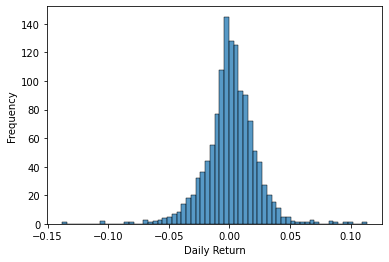

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.histplot(pc.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

In [6]:
mean = pc.mean()
var = pc.var()
drift = mean - 0.5*var
print("mean={}, var={}, drift={}".format(mean, var, drift))


mean=0.0010296347549292085, var=0.0004421583980179461, drift=0.0008085555559202355


# Performing Random Walk

In [7]:
from datetime import date
from pandas.tseries.offsets import BDay

date_t0 = date(today_yyyy, today_mm, today_dd)
date_tn = date(forecast_tn_yyyy, forecast_tn_mm, forecast_tn_dd)

n_forecast = 0
_t0 = date_t0
while _t0 <= date_tn:
  n_forecast += 1
  _t0 += BDay(1)
# print("Simulation: From {} to {}; Business days={}".format(date_t0, date_tn, np.busday_count(date_t0, date_tn)))

<ipython-input-7-ed9a7b90421d>:9: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  while _t0 <= date_tn:


Shape=(24, 1000)


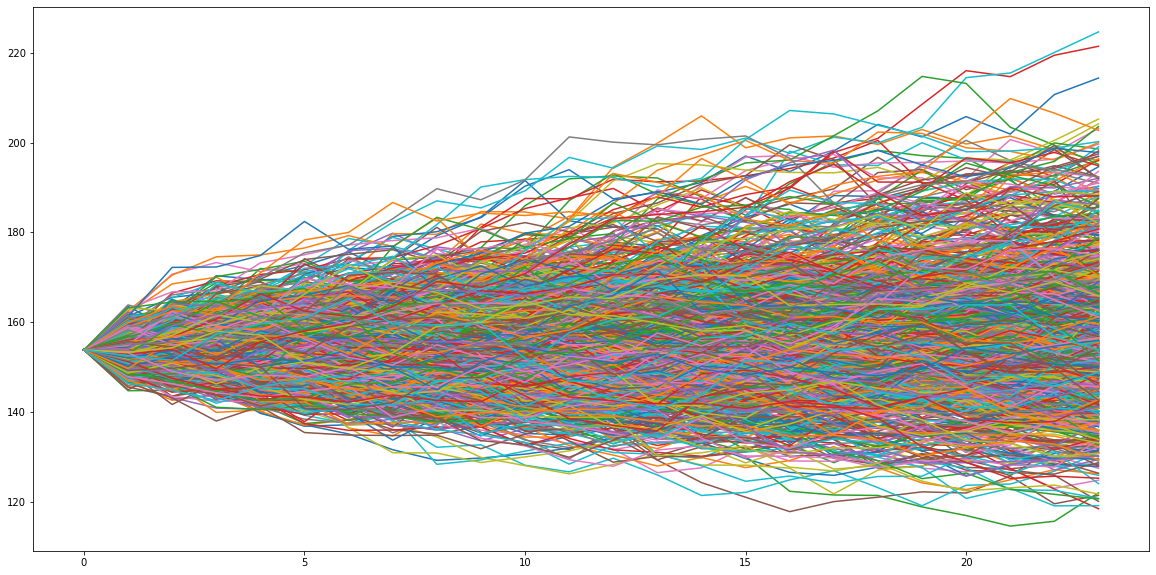

In [8]:
from scipy.stats import norm

stddev = pc.std()
rand_returns = np.exp(drift + stddev * norm.ppf(np.random.rand(n_forecast,n_iters)))


sim_equity_curve = np.zeros_like(rand_returns)
sim_equity_curve[0] = adj_close[len(adj_close)-1]
for t in range(1,n_forecast):
    sim_equity_curve[t] = sim_equity_curve[t-1]*rand_returns[t]
print("Shape="+str(sim_equity_curve.shape))


plt.figure(figsize=(20,10))
plt.plot(pd.DataFrame(sim_equity_curve).iloc[:,0:]);

In [9]:
count = 0
print("t+n; \t\t\t\tstd \t\tmean \t\tmean - 2*std \t\tmean + 2*std \n")
for e in sim_equity_curve:
  std = e.std()
  mean = e.mean()
  print("t+{} \t{} \tstd = {} \tmean = {} \tlower = {} \t\tupper = {}".format(count, date_t0+BDay(count), std.round(2), mean.round(2), (mean-2*std).round(2), (mean+2*std).round(2)))
  count += 1


t+n; 				std 		mean 		mean - 2*std 		mean + 2*std 

t+0 	2023-02-14 00:00:00 	std = 0.0 	mean = 153.85 	lower = 153.85 		upper = 153.85
t+1 	2023-02-15 00:00:00 	std = 3.21 	mean = 153.92 	lower = 147.49 		upper = 160.34
t+2 	2023-02-16 00:00:00 	std = 4.54 	mean = 154.26 	lower = 145.19 		upper = 163.33
t+3 	2023-02-17 00:00:00 	std = 5.57 	mean = 154.47 	lower = 143.33 		upper = 165.6
t+4 	2023-02-20 00:00:00 	std = 6.37 	mean = 154.54 	lower = 141.81 		upper = 167.27
t+5 	2023-02-21 00:00:00 	std = 7.19 	mean = 154.8 	lower = 140.43 		upper = 169.17
t+6 	2023-02-22 00:00:00 	std = 7.95 	mean = 154.89 	lower = 138.98 		upper = 170.8
t+7 	2023-02-23 00:00:00 	std = 8.63 	mean = 155.2 	lower = 137.95 		upper = 172.46
t+8 	2023-02-24 00:00:00 	std = 9.3 	mean = 155.49 	lower = 136.89 		upper = 174.08
t+9 	2023-02-27 00:00:00 	std = 9.81 	mean = 155.57 	lower = 135.96 		upper = 175.19
t+10 	2023-02-28 00:00:00 	std = 10.47 	mean = 155.78 	lower = 134.83 		upper = 176.72
t+11 	2023-03-01 